In [84]:
#import the libraries we may use
import numpy as np
import pandas as pd
import pickle
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

Building the data

In [85]:
#use the dataset stored in a pickle file
with open('song_df_aggregate.pkl', 'rb') as f:
        df = pickle.load(f)

In [86]:
#we select only songs released before the 2019-10-5
#and to use first rank, we delete the songs which first rank is inferior to 10 to avoid leakage
dataset=df[df.date<"2019-10-05"][df.firstrank>10]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [87]:
#we delete rows with NaN on those columns
#due to spotify's lack of information on some songs 

nan_col=["spotify_duration_ms","spotify_track_number","spotify_danceability","spotify_energy","spotify_loudness",
            "spotify_mode","spotify_speechiness","spotify_acousticness","spotify_instrumentalness",
           "spotify_liveness","spotify_valence","spotify_tempo","spotify_time_signature","artist_has_award"]

dataset=dataset.dropna(axis=0,subset=nan_col)

In [88]:
#delete unuseful features
dataset=dataset.drop(["release_year","label_category","artist","title","spotify_album_id",
                      "spotify_album_release_date_precision","album_label","datetime","join",
                      "spotify_id","spotify_disc_number","spotify_album_release_date","spotify_key",
                      "top50","top25","top75","top5","spotify_album_release_date_datetime",
                      "first_date","datetime","isnew","rank","release_month","last_award_type","label_appearance_count","label_appearance_count_group","numberofappearances"],axis=1)

In [90]:
#summary of the dataset infos
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7889 entries, 174 to 8518
Data columns (total 30 columns):
date                                7889 non-null object
spotify_explicit                    7889 non-null object
spotify_duration_ms                 7889 non-null float64
spotify_track_number                7889 non-null float64
spotify_danceability                7889 non-null float64
spotify_energy                      7889 non-null float64
spotify_loudness                    7889 non-null float64
spotify_mode                        7889 non-null float64
spotify_speechiness                 7889 non-null float64
spotify_acousticness                7889 non-null float64
spotify_instrumentalness            7889 non-null float64
spotify_liveness                    7889 non-null float64
spotify_valence                     7889 non-null float64
spotify_tempo                       7889 non-null float64
spotify_time_signature              7889 non-null float64
num_artists            

In [9]:
#train and test set split
test_set=dataset[dataset.date>="2016-06-11"]
train_set=dataset[dataset.date<"2016-06-11"]

In [91]:
len(test_set)/len(dataset)

0.2030675624286982

In [92]:
ytrain=train_set["top10"]
ytest=test_set["top10"]
train=train_set.drop(["date","bestrank"],axis=1)
test=test_set.drop(["date","top10","bestrank"],axis=1)

In [93]:
#we encode the categorical variables 
le = preprocessing.LabelEncoder()
train['label_category_group'] = le.fit_transform(train['label_category_group'].astype(str))
train['album_type'] = le.fit_transform(train['album_type'].astype(str))
train['spotify_explicit'] = le.fit_transform(train['spotify_explicit'].astype(str))
train["datetime_year"]=le.fit_transform(train["datetime_year"])
train["datetime_month"]=le.fit_transform(train["datetime_month"])
train["top10"]=le.fit_transform(train["top10"])

test['label_category_group'] = le.fit_transform(test['label_category_group'].astype(str))
test['album_type'] = le.fit_transform(test['album_type'].astype(str))
test["datetime_year"]=le.fit_transform(test["datetime_year"])
test["datetime_month"]=le.fit_transform(test["datetime_month"])
test['spotify_explicit'] = le.fit_transform(test['spotify_explicit'].astype(str))

ytrain=pd.DataFrame(le.fit_transform(ytrain),columns=["top10"])
ytest=pd.DataFrame(le.fit_transform(ytest),columns=["top10"])

In [94]:
#verify the type of the dataset
test.dtypes  

spotify_explicit                      int32
spotify_duration_ms                 float64
spotify_track_number                float64
spotify_danceability                float64
spotify_energy                      float64
spotify_loudness                    float64
spotify_mode                        float64
spotify_speechiness                 float64
spotify_acousticness                float64
spotify_instrumentalness            float64
spotify_liveness                    float64
spotify_valence                     float64
spotify_tempo                       float64
spotify_time_signature              float64
num_artists                         float64
award_num                           float64
gold_count                          float64
platinum_count                      float64
artist_has_award                       bool
num_songs_awards                    float64
firstrank                             int64
label_category_group                  int32
album_type                      

In [95]:
# #to pickle to share with others
# test.to_pickle("test_set.pkl")
# ytrain.to_pickle("ytrain.pkl")
# train.to_pickle("train_set.pkl")
# ytest.to_pickle("ytest.pkl")

Building models

In [97]:
#we use here again the SMOTE technique to balance our dataset

from imblearn.over_sampling import SMOTE
y=ytrain.values.reshape((-1,)) #shape needed for SMOTE
train.columns = train.columns.str.strip()
sm = SMOTE(random_state=42)
train, ytrain = sm.fit_resample(train,y)

In [98]:
len(train)

10940

In [99]:
train=train.drop(["top10"],axis=1)

In [100]:
#basic Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)

#basic random forest
rfc.fit(train,ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [101]:
#prediction
rfc_predict = rfc.predict(test)
print(confusion_matrix(rfc_predict,ytest))

[[1425   76]
 [  81   20]]


In [102]:

# Record the feature importances
feature_importances = rfc.feature_importances_
for i in range(len(feature_importances)):
    print(feature_importances[i],train.columns[i])

0.027364418992522305 spotify_explicit
0.03651924562288483 spotify_duration_ms
0.038746974067541365 spotify_track_number
0.053482353533710586 spotify_danceability
0.04241878979413063 spotify_energy
0.029940902426950355 spotify_loudness
0.10707332729465391 spotify_mode
0.05764506498118279 spotify_speechiness
0.037881450776708334 spotify_acousticness
0.02182769100371082 spotify_instrumentalness
0.02907100165617432 spotify_liveness
0.0340274182021949 spotify_valence
0.02986954715738928 spotify_tempo
0.005313221557194349 spotify_time_signature
0.07056523601943326 num_artists
0.028966165833728633 award_num
0.04016730405671397 gold_count
0.03178703429156032 platinum_count
0.005830061901342779 artist_has_award
0.04217779454164381 num_songs_awards
0.08801675613156906 firstrank
0.02100066882605432 label_category_group
0.011456346407591175 album_type
0.05105653605291149 datetime_year
0.022464497406013962 datetime_month
0.022808687260509487 numberofappearances_artist
0.012521504203978927 numberofa

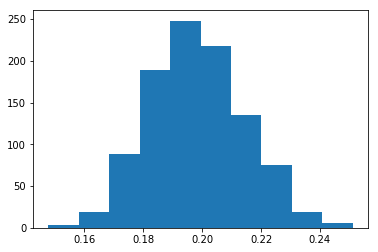

95.0 confidence interval 16.9% and 23.0%


In [114]:
from sklearn.utils import resample
df = test.copy()
df["top10"] = ytest.values
stats = list()
for i in range(1000):
    boot = resample(df, replace=True, n_samples=10000)
    boot_y = boot.pop("top10")
    boot_pred = rfc.predict(boot)
   
    precision = (confusion_matrix(boot_y,boot_pred)[1][1]) / (confusion_matrix(boot_y,boot_pred)[1][1] + confusion_matrix(boot_y,boot_pred)[0][1]) 
    stats.append(precision)
    
# plot scores
plt.hist(stats)
plt.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))